This notebook provides tutorials for the following decoding setup:

1. **(Custom dataset)** users provide their own spike features and behaviors
    
2. **(IBL)** work with public IBL datasets

3. **(CAVI)** example usage for binary behavioral correlates

In [1]:
import os
import sys
import time
import random
import numpy as np
import torch
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from density_decoding.utils.utils import set_seed

from density_decoding.utils.data_utils import (
    BaseDataLoader,
    IBLDataLoader, 
)
from density_decoding.decoders.behavior_decoder import (
    generic_decoder,
    sliding_window_decoder
)
from density_decoding.decode_pipeline import decode_pipeline

set_seed(666)

device = torch.device("cpu")

In [2]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 8
BIGGER_SIZE = 10
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

#### 1. Custom dataset

In this section, we provide a tutorial for running density-based decoding on your own data.

Here we use a toy example from a simulated dataset. First, let's load the simulated spike features and behaviors.

In [3]:
dir_path = Path("../toy_example")
sim_spike_features = np.load(dir_path / "spike_features.npy", allow_pickle=True)
sim_trial_idxs = np.load(dir_path / "trial_idxs.npy", allow_pickle=True)
sim_time_idxs = np.load(dir_path / "time_idxs.npy", allow_pickle=True)
sim_behaviors = np.load(dir_path / "behaviors.npy")

In [4]:
total_spike_features = np.concatenate(np.concatenate(sim_spike_features))
sim_spike_channels = total_spike_features.T[0]

There is a total of 281795 spikes and the spike feature dimension is 3:

In [5]:
print(total_spike_features[:,1:].shape)

(281716, 3)


These simulated spikes are detected on 50 electrodes:

In [6]:
print(np.unique(sim_spike_channels).shape)

(50,)


We have a total of 100 trials and each trial is partitioned into 30 time bins:

In [7]:
print(sim_behaviors.shape)

(100, 30)


Let's visualize the following spike features:
- location on the probe
- maximum peak-to-peak (maxptp) amplitude

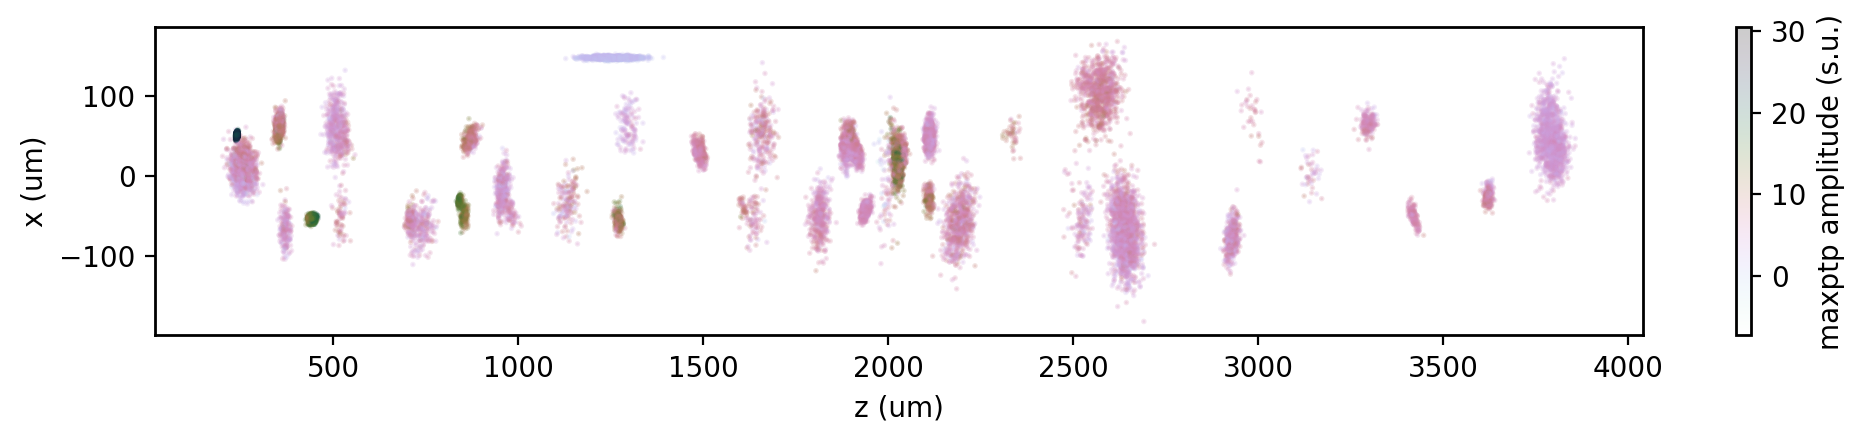

In [8]:
n_spikes_display = 2_0000
selected_spike_features = total_spike_features[:n_spikes_display,1:]
x, z, maxptp = selected_spike_features.T

fig, ax = plt.subplots(1, 1, figsize=(12,2))
im = ax.scatter(z, x, c=maxptp, s=1, alpha=.2, cmap="cubehelix_r")
cbar = plt.colorbar(im, ax=ax)
ax.set_xlabel("z (um)")
ax.set_ylabel("x (um)")
cbar.set_label("maxptp amplitude (s.u.)")
plt.show()

Then, we visualize the behavioral correlate that we want to decode:

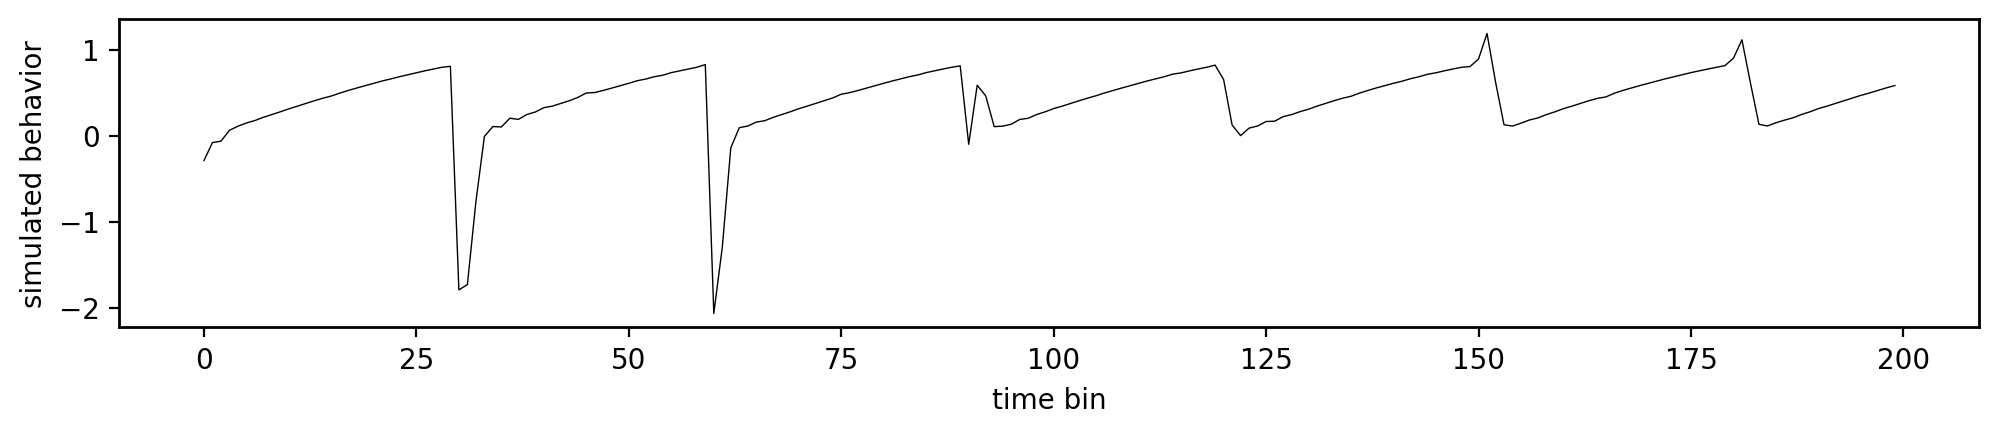

In [9]:
plt.figure(figsize=(12,2))
plt.plot(sim_behaviors.flatten()[:200], c="k", linewidth=.5)
plt.xlabel("time bin")
plt.ylabel("simulated behavior")
plt.show()

Let's split the trials into train and test sets:

In [10]:
trial_idxs = np.arange(len(sim_behaviors))
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.2)

In [11]:
custom_data_loader = BaseDataLoader(
    # use your own trial length (sec); the simulated trial length is 1.5 sec
    t_before=0.5,
    t_after=1.5,
    n_t_bins = 30
)

Let's try using outputs from multi-unit thresholding to decode the continuous behavior:

In [12]:
n_trials, n_t_bins = sim_behaviors.shape
n_channels = sim_spike_channels.max().astype(int) + 1

thresholded_spike_count = np.zeros([n_trials, n_channels, n_t_bins])
for k in range(n_trials):
    for t in range(n_t_bins):
        mask = np.logical_and(
            np.concatenate(sim_trial_idxs) == k,
            np.concatenate(sim_time_idxs) == t,
        )
        spike_count = np.zeros(n_channels).astype(int)
        sub_spike_channels = sim_spike_channels[mask].astype(int)
        np.add.at(spike_count, sub_spike_channels, 1)
        thresholded_spike_count[k,:,t] = spike_count
        
print(thresholded_spike_count.shape)

(100, 50, 30)


In [23]:
_, y_test, thresh_pred, metrics = generic_decoder(
    thresholded_spike_count, sim_behaviors, train, test, behavior_type="continuous", verbose=True
)

R2: 0.525, MSE: 0.110, Corr: 0.967


**Now we are ready to start decoding!**

In [26]:
start_time = time.time()

weight_matrix = decode_pipeline(
    custom_data_loader,
    sim_spike_features,
    sim_trial_idxs,
    sim_time_idxs,
    thresholded_spike_count,
    sim_behaviors,
    behavior_type = "continuous",
    train = train,
    test = test,
    learning_rate=1e-2,
    max_iter=10000,
    batch_size=1
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|███████████████████████████| 50/50 [00:02<00:00, 24.22it/s]


Initialized a mixture with 50 components.


Compute weight matrix: 100%|██████████████████| 100/100 [00:04<00:00, 23.54it/s]

time spent: 121.58655166625977 seconds


In [27]:
_, y_test, density_pred, metrics = generic_decoder(
    weight_matrix, sim_behaviors, train, test, behavior_type="continuous", verbose=True
)

R2: 0.533, MSE: 0.108, Corr: 0.966


We visually compare the decoded behavior traces from our method to the spike-thresholded decoder:

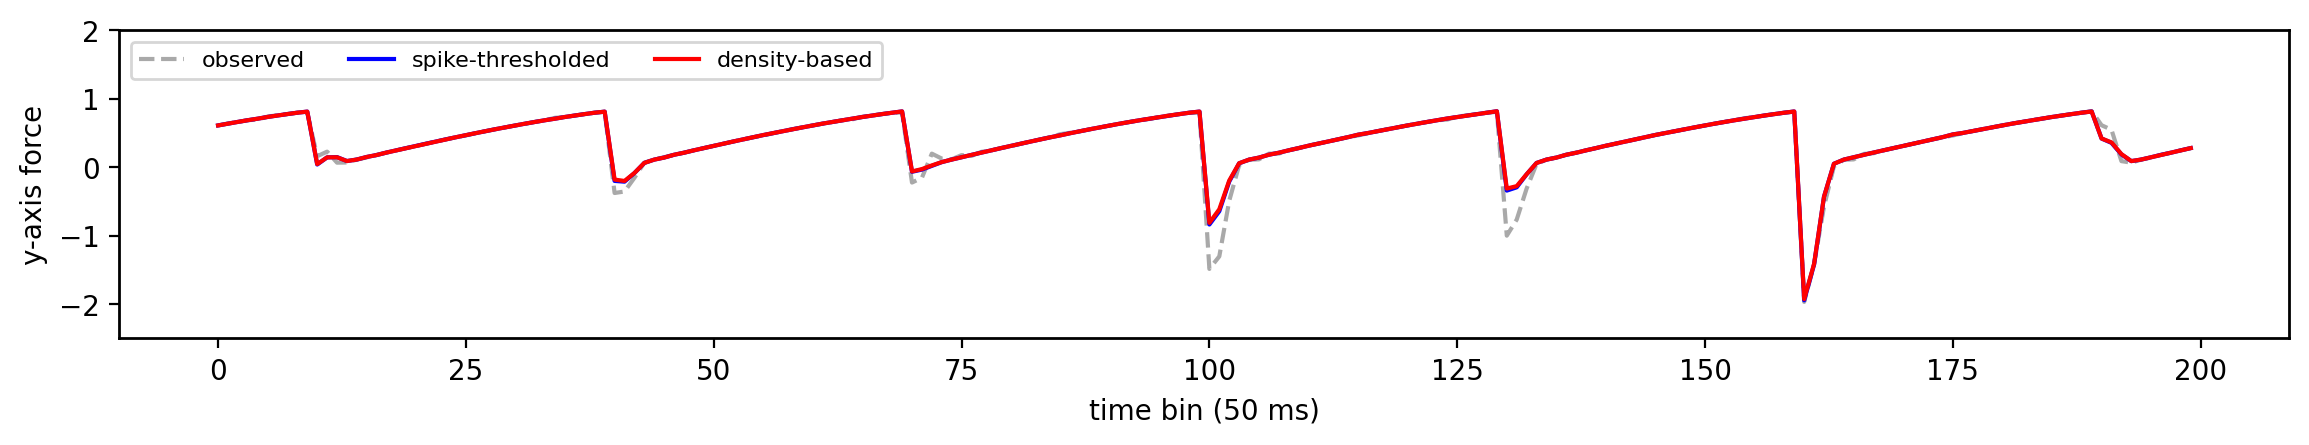

In [30]:
plt.figure(figsize=(14,2))
plt.plot(y_test.flatten()[200:400], c="darkgray", linestyle="--", label="observed")
plt.plot(thresh_pred.flatten()[200:400], c="blue", linestyle="-", label="spike-thresholded")
plt.plot(density_pred.flatten()[200:400], c="red", linestyle="-", label="density-based")
plt.xlabel("time bin (50 ms)")
plt.ylabel("y-axis force")
plt.legend(ncol=3, loc="upper left")
plt.ylim(-2.5, 2.)
plt.show()

#### 2. IBL

We also include a tutorial for working with IBL datasets, which are public and free to download.

First, let's prepare the IBL data loader (this function takes a while to pull data from the IBL database). 

In [4]:
pid = "dab512bd-a02d-4c1f-8dbc-9155a163efc0"

In [3]:
ibl_data_loader = IBLDataLoader(
    pid, 
    align_time_type='stimOn_times',
    t_before=0.5,
    t_after=1.0,
    n_t_bins = 30,
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367
prior for this session is not found.
found 367 trials from 17.56 to 2310.24 sec.


We can check the available brain regions for decoding:

In [4]:
ibl_data_loader.check_available_brain_regions()

['CA1' 'DG-mo' 'DG-po' 'DG-sg' 'Eth' 'LP' 'PO' 'TH' 'VISam5' 'VISam6a'
 'VPLpc' 'alv' 'cing' 'fp' 'ml' 'or']


We want to decode the following behavioral correlates:
   - **Choice**: binary variable of size (n_trials,)
   - **Motion energy**: continuous variable of size (n_trials, n_time_bins)

In [5]:
motion_energy = ibl_data_loader.process_behaviors("motion_energy")
motion_energy /= motion_energy.max()

Then, we load the **spike times**, **spike channels** and **spike features**. 

In [8]:
dir_path = Path("/mnt/3TB/yizi/danlab/Subjects/DY_016/subtract_res_wf_pcs/")
spike_index = np.load(dir_path / "spike_index.npy")
spike_features = np.load(dir_path / "localization_results.npy")
spike_times, spike_channels = spike_index.T

Here is a visualization of the spike features:

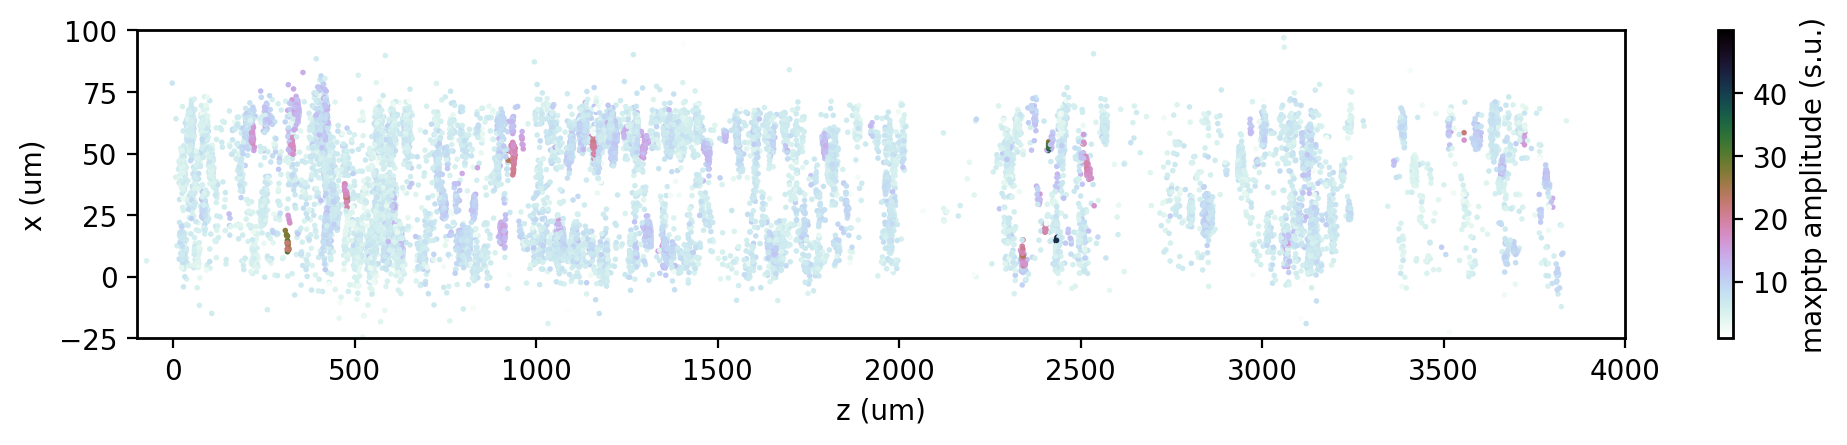

In [35]:
n_spikes_display = 2_0000
x, z, maxptp = spike_features[:n_spikes_display].T

fig, ax = plt.subplots(1, 1, figsize=(12,2))
im = ax.scatter(z, x, c=maxptp, s=1, alpha=1., cmap="cubehelix_r")
cbar = plt.colorbar(im, ax=ax)
ax.set_xlim(-100, 4000)
ax.set_ylim(-25, 100)
ax.set_xlabel("z (um)")
ax.set_ylabel("x (um)")
cbar.set_label("maxptp amplitude (s.u.)")
plt.show()

As an examle, we use spike features from the brain region **LP** to decode motion energy:

In [7]:
brain_region = "lp"

In [37]:
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features, brain_region
    )

found 82 channels in region lp


Process spike features: 100%|████████████████| 367/367 [00:02<00:00, 143.54it/s]


Again, multi-unit thresholding is a prerequisite for the decoding pipeline:

In [38]:
thresholded_spike_count = ibl_data_loader.load_thresholded_units(
    spike_times, spike_channels, brain_region
)

found 82 channels in region lp


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 1721.15it/s]


Next, we split the trials into train and test sets:

In [7]:
trial_idxs = np.arange(ibl_data_loader.n_trials)
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.2)

**And we are ready for density-based decoding :)**

In [48]:
start_time = time.time()

weight_matrix = decode_pipeline(
    ibl_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    thresholded_spike_count,
    bin_behaviors = motion_energy,
    behavior_type = "continuous",
    train = train,
    test = test,
    learning_rate=1e-2,
    max_iter=10000,
    batch_size=32
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|███████████████████████████| 81/81 [00:03<00:00, 23.89it/s]


Initialized a mixture with 114 components.


Compute weight matrix: 100%|██████████████████| 367/367 [00:33<00:00, 10.90it/s]


time spent: 363.0911543369293 seconds


In [49]:
_, _, our_pred, metrics = sliding_window_decoder(
    weight_matrix, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.635, MSE: 0.006, Corr: 0.799


Now we can load sorting results from Kilosort 2.5 and evaluate its decoding performance:

In [44]:
all_sorted_spike_count = ibl_data_loader.load_all_sorted_units(brain_region)

found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 1117.43it/s]


In [45]:
_, y_test, ks_pred, metrics = sliding_window_decoder(
    all_sorted_spike_count, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.641, MSE: 0.006, Corr: 0.803


We visually compare the decoded behavior traces from our method to the spike-sorted decoder:

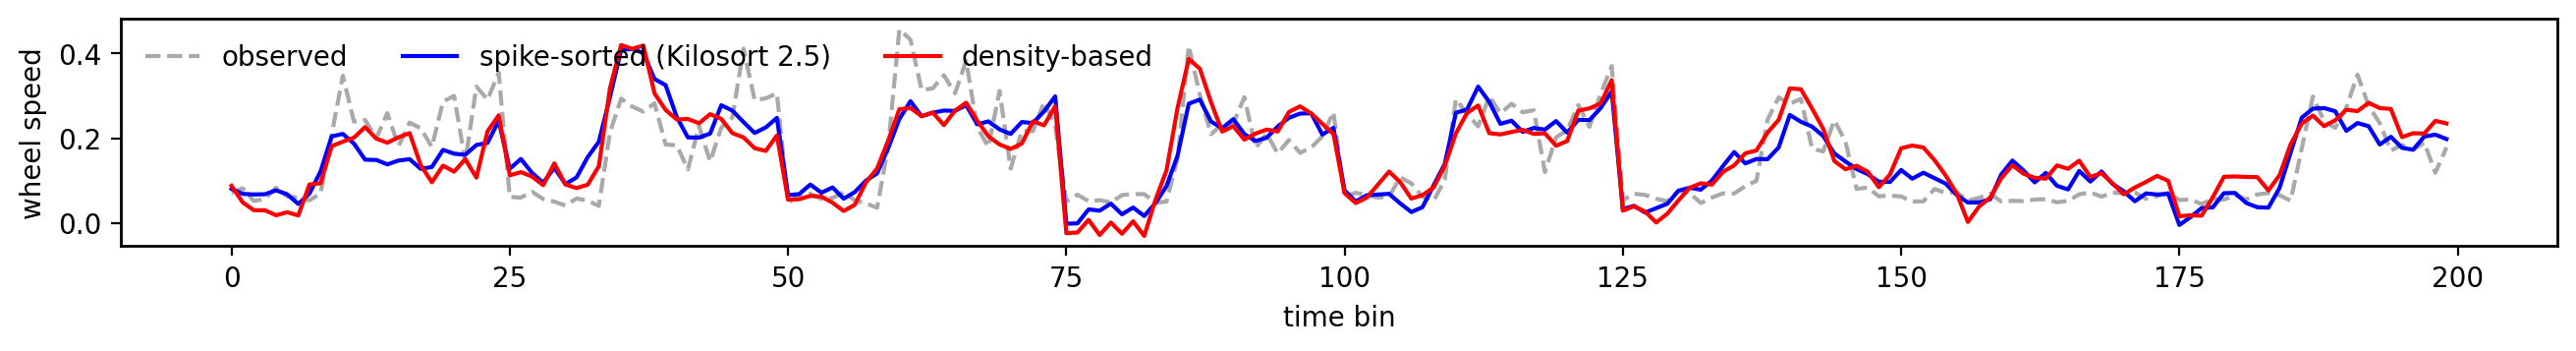

In [52]:
plt.figure(figsize=(16,1.5))
plt.plot(y_test[200:400], c="darkgray", linestyle="--", label="observed")
plt.plot(ks_pred[200:400], c="blue", linestyle="-", label="spike-sorted (Kilosort 2.5)")
plt.plot(our_pred[200:400], c="red", linestyle="-", label="density-based")
plt.xlabel("time bin")
plt.ylabel("wheel speed")
plt.legend(ncol=3, loc="upper left", fontsize=10, frameon=False)
plt.show()

We can also check how decoding using only **"good" Kilosort units** that pass the quality check does:

In [53]:
good_sorted_spike_count = ibl_data_loader.load_good_sorted_units(brain_region)

found 20 good units in region lp


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 4534.20it/s]


In [54]:
_, _, _, _ = sliding_window_decoder(
    good_sorted_spike_count, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.453, MSE: 0.009, Corr: 0.675


We can also compare our method to spike-thresholded decoder, and ours is better.

In [55]:
_, _, _, _ = sliding_window_decoder(
    thresholded_spike_count, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.597, MSE: 0.007, Corr: 0.778


Moving onto decoding the binary choice. Using a smaller `n_time_bins` usually gives us a higher decoding accuracy.

In [5]:
ibl_data_loader = IBLDataLoader(
    pid, 
    t_before = 0.5,
    t_after = 1.0,
    n_t_bins = 10
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367
prior for this session is not found.
found 367 trials from 17.56 to 2310.24 sec.


In [9]:
choice = ibl_data_loader.process_behaviors("choice")

In [11]:
brain_region = "lp"

In [ ]:
dir_path = Path("/mnt/3TB/yizi/danlab/Subjects/DY_016/subtract_res_wf_pcs/")
spike_index = np.load(dir_path / "spike_index.npy")
spike_features = np.load(dir_path / "localization_results.npy")
spike_times, spike_channels = spike_index.T

In [12]:
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features, brain_region
    )

found 82 channels in region lp


Process spike features: 100%|████████████████| 367/367 [00:02<00:00, 139.29it/s]


In [13]:
thresholded_spike_count = ibl_data_loader.load_thresholded_units(
    spike_times, spike_channels, brain_region
)

found 82 channels in region lp


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 1643.02it/s]


In [14]:
start_time = time.time()

weight_matrix = decode_pipeline(
    ibl_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    thresholded_spike_count,
    bin_behaviors = choice,
    behavior_type = "discrete",
    train = train,
    test = test,
    learning_rate=1e-3,
    max_iter=10000,
    batch_size=32
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|███████████████████████████| 81/81 [00:03<00:00, 26.77it/s]


Initialized a mixture with 114 components.


Compute weight matrix: 100%|██████████████████| 367/367 [00:08<00:00, 41.31it/s]

time spent: 163.42971968650818 seconds


In [15]:
_, _, _, _ = generic_decoder(
    weight_matrix, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.730
auc: 0.629


In [16]:
_, _, _, _ = generic_decoder(
    thresholded_spike_count, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.689
auc: 0.601


The choice decoding accuracy from the spike-sorted decoder is:

In [17]:
all_sorted_spike_count = ibl_data_loader.load_all_sorted_units(brain_region)

found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 1163.16it/s]


In [18]:
_, _, _, _ = generic_decoder(
    all_sorted_spike_count, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.784
auc: 0.734


The accuracy using the decoder based on the "good" Kilosort units is:

In [19]:
good_sorted_spike_count = ibl_data_loader.load_good_sorted_units(brain_region)

found 20 good units in region lp


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 4718.84it/s]


In [20]:
_, _, _, _ = generic_decoder(
    good_sorted_spike_count, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.730
auc: 0.663


#### 3. CAVI

Although we recommend decoding everything using ADVI as the default inference method, we also include a tutorial for using CAVI for decoding binary behavioral correlates:

In [28]:
start_time = time.time()

weight_matrix = decode_pipeline(
    ibl_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    thresholded_spike_count,
    bin_behaviors = choice,
    behavior_type = "discrete",
    train = train,
    test = test,
    inference = "cavi",
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|███████████████████████████| 81/81 [00:02<00:00, 27.13it/s]


Initialized a mixture with 114 components.


Compute weight matrix: 100%|██████████████████| 367/367 [00:07<00:00, 49.78it/s]

time spent: 475.2217421531677 seconds


In [29]:
_, _, _, _ = generic_decoder(
    weight_matrix, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.689
auc: 0.601
